In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

#  클라이언트 설정



### 데이터셋 준비

In [84]:
query = """
with raw as 
  (
    select 
      order_dt, order_no, member_no
      ,sum(first_pay_amt) as first_pay_amt, sum(first_sub_pay_amt) as first_sub_pay_amt
  from
    (
      select 
        order_dt, order_no, member_no, first_pay_amt, first_sub_pay_amt
      from ballosodeuk.dw.fact_shopby_order, unnest(product_option)
      where 1=1
        and length(claim_status_type) < 1
        and date(order_dttm) > "2024-12-30")
    group by order_dt, order_no, member_no
  )

,merge_raw as (
  select 
    user_id, 
    order_dt,
    sum(first_pay_amt) as first_pay_amt, 
    sum(first_sub_pay_amt) as first_sub_pay_amt
  from (
    select b.wk_id as user_id, a.*
    from raw a
    left join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
  )
  group by user_id, order_dt
)

,daily_net_amount as 
    (select 
        register_dt, member_no, sum(coalesce(earn,0) - coalesce(cancel,0)) as num
    from
        (SELECT 
            register_dt, member_no,
                CASE WHEN accumulation_status IN ('취소로 인한 지급','지급') THEN amt END as earn,
                CASE WHEN accumulation_status IN ('차감') THEN amt END as cancel
        FROM ballosodeuk.dw.fact_shopby_reward)
    group by register_dt, member_no)

,exception_case as (
  select register_dt, user_id, sum(amt) as amt, "소멸" as reason
  from 
    (select register_dt, a.member_no, wk_id as user_id, amt, reason
    from ballosodeuk.dw.fact_shopby_reward a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    where reason ="유효기간 만료")
  group by register_dt, user_id
)

,exception_case_2 as (
  select register_dt, user_id, sum(amt) as amt, "교환권" as reason
  from
    (select register_dt, a.member_no, wk_id as user_id, amt
    from ballosodeuk.dw.fact_shopby_reward a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    where 1=1
      and reason = "운영자 지급" 
      and reason_detail like "%교환%" or reason_detail in("쇼핑지원금 상품권 적립","쇼핑지원금 교환권 적립","쇼핑지원금 환전","쇼핑지원금 5,000원 교환 쿠폰","쇼핑지원금 전환"))
  group by register_dt, user_id
)

,cumulative_amount as (
    select register_dt, member_no, num as daily_net_amount,
        sum(num) over (
            partition by member_no
            order by register_dt
            rows between unbounded preceding and current row
        ) as cummulative_amount
    from daily_net_amount
)

,merged_ as 
    (select b.wk_id as user_id, gender, 
      cast(floor(
        DATE_DIFF(
          DATE(FORMAT_DATE('%Y-01-01', CURRENT_DATE())), -- 현재 년도의 1월 1일
          DATE(SAFE_CAST(birth_year AS INT64), 1, 1),    -- birth_year의 1월 1일
          YEAR  -- 년 단위로 차이 계산
        ) / 10) * 10 as int64) as age
        ,a.* except(member_no)
    from cumulative_amount a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    order by user_id, register_dt
    )

,merged as 
  (select register_dt, user_id, gender,age,
    lag(cummulative_amount) over (partition by user_id order by register_dt asc) as pre_shoji,
    cummulative_amount as current_shoji,
    lead(cummulative_amount,1) over (partition by user_id order by register_dt asc) as post_shoji_1,
    lead(cummulative_amount,2) over (partition by user_id order by register_dt asc) as post_shoji_2,
    lead(cummulative_amount,3) over (partition by user_id order by register_dt asc) as post_shoji_3,
    lead(cummulative_amount,4) over (partition by user_id order by register_dt asc) as post_shoji_4,
    lead(cummulative_amount,5) over (partition by user_id order by register_dt asc) as post_shoji_5,
    lead(cummulative_amount,6) over (partition by user_id order by register_dt asc) as post_shoji_6,
    lead(cummulative_amount,7) over (partition by user_id order by register_dt asc) as post_shoji_7,
    lead(cummulative_amount,8) over (partition by user_id order by register_dt asc) as post_shoji_8,
    lead(cummulative_amount,9) over (partition by user_id order by register_dt asc) as post_shoji_9,
    lead(cummulative_amount,10) over (partition by user_id order by register_dt asc) as post_shoji_10,
    lead(cummulative_amount,11) over (partition by user_id order by register_dt asc) as post_shoji_11,
    lead(cummulative_amount,12) over (partition by user_id order by register_dt asc) as post_shoji_12,
    lead(cummulative_amount,13) over (partition by user_id order by register_dt asc) as post_shoji_13
    
  from merged_ )

,df as 
  (select 
    a.register_dt, a.user_id, gender,age, pre_shoji, current_shoji
    ,post_shoji_1, post_shoji_2, post_shoji_3, post_shoji_4, post_shoji_5, post_shoji_6, post_shoji_7, post_shoji_8, post_shoji_9, post_shoji_10, post_shoji_11, post_shoji_12, post_shoji_13
    ,first_pay_amt, first_sub_pay_amt, c.amt as burnt, d.amt as exchange,
    round(first_sub_pay_amt / first_pay_amt,2) as sub_power
  from merged a
  inner join merge_raw b on a.user_id = b.user_id and a.register_dt = b.order_dt
  left join exception_case c on c.user_id = a.user_id and a.register_dt = c.register_dt
  left join exception_case_2 d on d.user_id = a.user_id and a.register_dt = d.register_dt)


select * from df
"""

In [210]:
df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [211]:
df = df.query("user_id.notnull()")
df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)
df['register_dt'] = pd.to_datetime(df.register_dt.astype(str))
# # int, float 컬럼의 NA를 0으로 채우기
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
df[numeric_columns] = df[numeric_columns].fillna(0)
df.fillna(0, inplace=True)

origin_df = df.copy(deep=True)
df = df.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last')

<ipython-input-211-35513c4167cf>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)


In [201]:
origin_df.groupby('user_id').agg({'register_dt':'count'}).query('register_dt > 1')

,register_dt
user_id,
00513524-5e65-480c-8c7d-3d09595b0365,2
008782c2-079d-4d5a-8813-b828226b59dc,2
01972243-698b-4345-9cad-c6beb8a343cc,2
01b20c63-8377-4ef9-9f8b-97b54f4a3b42,2
01ded026-3b82-4bcf-8a50-8592cd9c4346,2
...,...
ff53a880-b085-418a-b347-deddcae30816,2
ff620558-1106-422c-9439-04e980b5bd9c,2
ffa69507-a4d4-4cd8-9863-c0d13a5bdd57,2


In [89]:
df.query("user_id == 'f732be14-bde6-4833-9643-82144089b223'").sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last')

,register_dt,user_id,gender,age,pre_shoji,current_shoji,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,...,post_shoji_9,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,first_pay_amt,first_sub_pay_amt,burnt,exchange,sub_power
4595,2025-01-11,f732be14-bde6-4833-9643-82144089b223,FEMALE,60,303,303,312,0,0,0,...,0,0,0,0,0,17800,890,4375,0,0


In [90]:
df.info()
df.exchange.value_counts()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7037 entries, 0 to 7914
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   register_dt        7037 non-null   datetime64[ns]
 1   user_id            7037 non-null   object        
 2   gender             7037 non-null   object        
 3   age                7037 non-null   Int64         
 4   pre_shoji          7037 non-null   Int64         
 5   current_shoji      7037 non-null   Int64         
 6   post_shoji_1       7037 non-null   Int64         
 7   post_shoji_2       7037 non-null   Int64         
 8   post_shoji_3       7037 non-null   Int64         
 9   post_shoji_4       7037 non-null   Int64         
 10  post_shoji_5       7037 non-null   Int64         
 11  post_shoji_6       7037 non-null   Int64         
 12  post_shoji_7       7037 non-null   Int64         
 13  post_shoji_8       7037 non-null   Int64         
 14  post_sho

0        5772
100       775
300       261
500       119
1000       45
5000       27
3000       24
10000       9
5100        4
5300        1
Name: exchange, dtype: Int64

### 총 통계 처리

In [91]:
## 교환권 구매 유저 중, 교환권 구매 후 1000원 이하로 남은 유저 비율
df[(df.post_shoji_1 < 1000) & (df.exchange > 0)].user_id.nunique() / df[df.exchange > 0].user_id.nunique()

0.8023715415019763

In [92]:
# current - post 차이는 26원 수준. 20일의 post는 current 로 보간 가능.
print(
    (df.query("register_dt < '2025-01-20'").current_shoji - df.query("register_dt < '2025-01-20'").post_shoji_1).mean()
    )


-31.247196261682245


In [93]:
df.loc[df['register_dt'] == '2025-01-20', 'post_shoji_1'] = df.loc[df['register_dt'] == '2025-01-20', 'current_shoji']
df['using_power'] = df['first_sub_pay_amt'] / (df['post_shoji_1'] + df['first_sub_pay_amt'])
df

,register_dt,user_id,gender,age,pre_shoji,current_shoji,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,...,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,first_pay_amt,first_sub_pay_amt,burnt,exchange,sub_power,using_power
0,2024-12-31,560f04a5-9cbd-49b2-bf84-552ccd349c30,MALE,40,16080,242,267,363,372,385,...,0,0,0,0,15900,15900,0,0,1,0.983485
421,2024-12-31,b6b24dfc-ef4b-48c0-8bc8-e18bd9d0dd66,FEMALE,40,41498,16,32,422,447,872,...,1153,1308,1333,1343,45700,41508,0,0,0,0.99923
422,2024-12-31,d0e37fe5-5f0f-4b65-8d74-e7f86dca7670,FEMALE,50,840,0,15,0,0,0,...,0,0,0,0,12900,840,0,0,0,0.982456
423,2024-12-31,15bc7567-d0e3-424f-9c3e-70334ecf1231,FEMALE,20,5,32,60,80,96,105,...,0,0,0,0,10800,540,0,0,0,0.9
424,2024-12-31,6b5de387-97ff-4205-aaa4-8ff4a805cf06,FEMALE,40,0,7,13,16,19,25,...,0,0,0,0,17800,890,0,0,0,0.985604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7704,2025-01-21,61ff0dc8-1978-4dee-ada3-78b383b4c090,MALE,60,1492,0,0,0,0,0,...,0,0,0,0,8900,1657,0,0,0,1.0
7703,2025-01-21,2990bbcd-286c-45d1-945a-40d7ad3d997b,MALE,30,1593,0,0,0,0,0,...,0,0,0,0,21500,1643,0,0,0,1.0
7702,2025-01-21,c18d2b52-94fa-48cb-8f5c-38e0c0d74c57,FEMALE,50,25,38,0,0,0,0,...,0,0,0,0,16800,280,0,0,0,1.0
7709,2025-01-21,30e5f85f-1472-4d44-8c88-125dc826a8fb,FEMALE,30,4865,0,0,0,0,0,...,0,0,0,0,4980,4946,0,0,0,1.0


In [94]:
## 쇼핑지원금 사용 강도의 통계 : 평균 83% 가량 사용.
df.using_power = df.using_power.replace('<NA>', np.nan)
df.using_power = df.using_power.astype(float)
df.using_power.isnull().sum()
df.using_power.fillna(0,inplace=True)

df.using_power.mean(), df.using_power.std()

(0.8369015666149894, 0.23740291387368148)

<ipython-input-95-bd064c66fd42>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-95-bd064c66fd42>:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
<ipython-input-95-bd064c66fd42>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=45, ha='right')


Text(0.5, 1.0, '쇼핑지원금 사용 강도 분포')

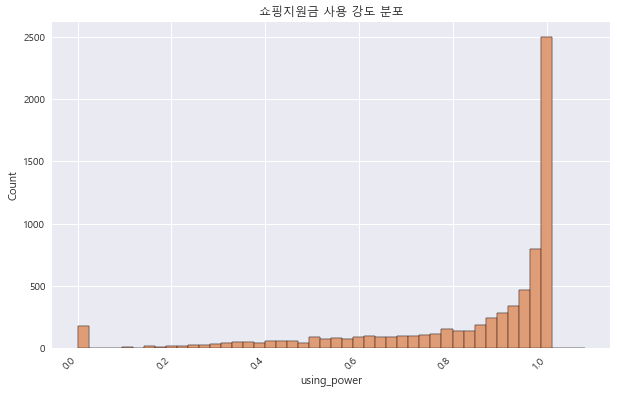

In [95]:
# 유저는 구매 시, 소지한 쇼핑지원금을 모두 사용하는 경향이 있다.
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
# 한글 폰트 설정
import matplotlib.font_manager as fm

# 폰트 경로 확인 및 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Malgun Gothic 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df.using_power, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('쇼핑지원금 사용 강도 분포', fontsize=12, pad=15)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 그래프 스타일 설정 
plt.style.use('seaborn')
sns.set_palette('Set2')

plt = sns.histplot(df.using_power)
plt.set_xticklabels(plt.get_xticklabels(), rotation=45, ha='right')
plt.set_title('쇼핑지원금 사용 강도 분포', fontsize=12)


In [96]:
len(df[df['using_power']> 0.95]) / len(df)

0.5108711098479466

In [97]:
df.columns

Index(['register_dt', 'user_id', 'gender', 'age', 'pre_shoji', 'current_shoji',
       'post_shoji_1', 'post_shoji_2', 'post_shoji_3', 'post_shoji_4',
       'post_shoji_5', 'post_shoji_6', 'post_shoji_7', 'post_shoji_8',
       'post_shoji_9', 'post_shoji_10', 'post_shoji_11', 'post_shoji_12',
       'post_shoji_13', 'first_pay_amt', 'first_sub_pay_amt', 'burnt',
       'exchange', 'sub_power', 'using_power'],
      dtype='object')

# 분석

### 7d 리텐션 분석

| 코호트 | 이탈 (7d) | 생존 (7d) | 모수 | 이탈율 | 생존율 |
|--------|-----------|-----------|------|--------|--------|
| 전체 모수 | 1,227 | 3,779 | 5,006 | 24.51% | 75.49% |
| 교환, 소각 x | 1,080 | 3,141 | 4,221 | 25.59% | 74.41% |
| 교환자 | 138 | 621 | 759 | 18.18% | 81.82% |
| 소각 | 9 | 18 | 27 | 33.33% | 66.67% |

In [107]:
df['spending_power'] = round(df.apply(lambda x: 0 if x['first_sub_pay_amt'] == 0 else x['first_sub_pay_amt'] / (x['first_sub_pay_amt'] + x['post_shoji_1']), axis=1), 2)
tst = df[df['register_dt'] < "2025-01-15" ][['register_dt','user_id','gender','age','burnt', 'exchange','first_pay_amt','first_sub_pay_amt','spending_power','post_shoji_1','post_shoji_6','post_shoji_13']]
tst['tst'] = tst['post_shoji_6'] > tst['post_shoji_1']
tst.groupby('tst').user_id.count()

tst
False    1147
True     3816
Name: user_id, dtype: int64

In [108]:
# 이탈과 비이탈의 재산 대비 소진율에 차이는 없음.
tst.groupby('tst').agg({'spending_power':['mean','std']})

spending_power          
                mean       std
tst                           
False       0.892276  0.221868
True        0.818142  0.230252

In [110]:
# 이탈과 비이탈의 재산 대비 소진율에 차이는 없음.
tst.groupby(['tst','gender','age']).agg({'spending_power':['mean','std']})

spending_power          
                           mean       std
tst   gender age                         
False FEMALE 10        0.975000  0.035355
             20        0.933387  0.159342
             30        0.946231  0.144229
             40        0.905649  0.187423
             50        0.870352  0.244448
             60        0.861081  0.256630
             70        0.872500  0.281913
             80        0.660000       NaN
      MALE   10        1.000000       NaN
             20        0.900769  0.275241
             30        0.925303  0.217675
             40        0.863085  0.248012
             50        0.867917  0.250056
             60        0.848182  0.290199
             70        0.829000  0.307732
             120       1.000000       NaN
True  FEMALE 10        0.770000  0.296985
             20        0.848026  0.200466
             30        0.846875  0.195050
             40        0.823750  0.223553
             50        0.815596  0.223115
             60        0.792595  0.261452
             70        0.813514  0.306061
             90        0.990000       NaN
      MALE   10        0.945000  0.035355
             20        0.771250  0.247279
             30        0.824492  0.206247
             40        0.848354  0.210778
             50        0.807343  0.240137
             60        0.782137  0.273016
             70        0.836389  0.223315
             80        0.920000  0.157003

In [100]:
tst

,register_dt,user_id,burnt,exchange,first_pay_amt,first_sub_pay_amt,spending_power,post_shoji_1,post_shoji_6,post_shoji_13,tst
0,2024-12-31,560f04a5-9cbd-49b2-bf84-552ccd349c30,0,0,15900,15900,0.98,267,0,0,False
421,2024-12-31,b6b24dfc-ef4b-48c0-8bc8-e18bd9d0dd66,0,0,45700,41508,1.00,32,922,1343,True
422,2024-12-31,d0e37fe5-5f0f-4b65-8d74-e7f86dca7670,0,0,12900,840,0.98,15,0,0,False
423,2024-12-31,15bc7567-d0e3-424f-9c3e-70334ecf1231,0,0,10800,540,0.90,60,139,0,True
424,2024-12-31,6b5de387-97ff-4205-aaa4-8ff4a805cf06,0,0,17800,890,0.99,13,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...
5568,2025-01-14,7d90c3b9-a0e6-4954-9e1a-b539506163fe,0,0,3900,3900,0.94,255,669,0,True
5569,2025-01-14,03a7d6b8-900e-487a-9fc2-9a79ad437507,0,0,20800,20800,0.97,536,0,0,False
5581,2025-01-14,e9f41706-7026-4fdb-8182-0b5a2235f5a2,0,100,4980,4980,0.80,1278,1623,0,True
5571,2025-01-14,71dfb183-8b46-4053-a701-f8c6a1466554,0,0,226000,11300,0.88,1547,1798,0,True


In [101]:
tst_d = tst[(tst['exchange']==0) & (tst['burnt']==0)]
tst_d['tst'] = tst_d['post_shoji_6'] > tst_d['post_shoji_1']
tst_d.groupby('tst').user_id.count()

<ipython-input-101-ea733f76e556>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_d['tst'] = tst_d['post_shoji_6'] > tst_d['post_shoji_1']


tst
False    1011
True     3175
Name: user_id, dtype: int64

In [102]:
# 교환자 생존율
exchange = tst[tst['exchange'] > 0]
exchange.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last', inplace=True)
exchange.groupby('tst').user_id.count()


tst
False    129
True     622
Name: user_id, dtype: int64

In [127]:
# 교환자 생존율
exchange = tst[tst['exchange'] > 0]
exchange.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last', inplace=True)
ex_ = pd.DataFrame(exchange.groupby(['tst','age']).user_id.count()).reset_index()

ex_ = pd.merge(
    ex_[ex_['tst']==False],
    ex_[ex_['tst']!=False],
    on='age',how='left'
)

ex_['user_id_x'] / sum(user_id)

,tst_x,age,user_id_x,tst_y,user_id_y
0,False,20,17,True,26
1,False,30,39,True,99
2,False,40,46,True,212
3,False,50,24,True,200
4,False,60,2,True,73
5,False,70,1,True,10


In [103]:
# 소각 시, 생존율
burnt = tst[tst['burnt'] > 0]
burnt.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last', inplace=True)
burnt.groupby('tst').user_id.count()

tst
False     7
True     20
Name: user_id, dtype: int64

In [104]:
exchange.sort_values('exchange', ascending=False)


,register_dt,user_id,burnt,exchange,first_pay_amt,first_sub_pay_amt,spending_power,post_shoji_1,post_shoji_6,post_shoji_13,tst
2963,2025-01-05,20bda4f9-1bad-46da-9b2b-ee41f4c88d99,0,10000,19700,19700,0.96,751,1098,0,True
5294,2025-01-13,7faf1ce5-5850-48b9-9bdc-1ddf31658070,0,10000,20800,20236,1.00,0,0,0,False
4821,2025-01-12,66c131dc-7891-4da7-8c0f-2434c3f10220,0,10000,11900,10540,1.00,0,0,0,False
2339,2025-01-04,b1766d85-988b-4311-a3cb-007df9ff0930,0,10000,11900,11900,0.91,1182,0,0,False
4856,2025-01-12,e966436e-b665-4876-9c64-cc16279b282b,0,10000,9900,9900,0.82,2117,2699,0,True
...,...,...,...,...,...,...,...,...,...,...,...
2893,2025-01-05,cc2f8b93-5f3b-4eb6-96a0-1e3376b31057,0,100,3900,1687,1.00,3,407,877,True
2890,2025-01-05,9c78309b-c8b9-4632-b5a3-846e0ba36c1f,0,100,5900,902,0.81,213,1611,2026,True
2858,2025-01-05,57a4d875-37a0-46b3-b7d8-c6222231ae71,0,100,12600,11335,1.00,28,341,931,True
2839,2025-01-05,89e8bd1b-b60f-4320-b14f-c874e4e99d5c,0,100,18900,1035,0.89,130,558,5971,True


In [105]:
df.user_id.nunique()
df[df['register_dt'] < "2025-01-15" ].user_id.nunique()


4963

### 인과 분석
재구매 유저는 행이 여러개임. 단, 매 구매 이후 이탈 확률은 동일하게 부여되므로, 독립적인 세션으로 취급.

In [213]:
origin = origin_df.copy(deep=True)
origin.columns

Index(['register_dt', 'user_id', 'gender', 'age', 'pre_shoji', 'current_shoji',
       'post_shoji_1', 'post_shoji_2', 'post_shoji_3', 'post_shoji_4',
       'post_shoji_5', 'post_shoji_6', 'post_shoji_7', 'post_shoji_8',
       'post_shoji_9', 'post_shoji_10', 'post_shoji_11', 'post_shoji_12',
       'post_shoji_13', 'first_pay_amt', 'first_sub_pay_amt', 'burnt',
       'exchange', 'sub_power'],
      dtype='object')

In [215]:
origin.columns

Index(['register_dt', 'user_id', 'gender', 'age', 'pre_shoji', 'current_shoji',
       'post_shoji_1', 'post_shoji_2', 'post_shoji_3', 'post_shoji_4',
       'post_shoji_5', 'post_shoji_6', 'post_shoji_7', 'post_shoji_8',
       'post_shoji_9', 'post_shoji_10', 'post_shoji_11', 'post_shoji_12',
       'post_shoji_13', 'first_pay_amt', 'first_sub_pay_amt', 'burnt',
       'exchange', 'sub_power'],
      dtype='object')

In [208]:
df.columns

Index(['register_dt', 'user_id', 'gender', 'age', 'pre_shoji', 'current_shoji',
       'post_shoji_1', 'post_shoji_2', 'post_shoji_3', 'post_shoji_4',
       'post_shoji_5', 'post_shoji_6', 'post_shoji_7', 'post_shoji_8',
       'post_shoji_9', 'post_shoji_10', 'post_shoji_11', 'post_shoji_12',
       'post_shoji_13', 'first_pay_amt', 'first_sub_pay_amt', 'burnt',
       'exchange', 'sub_power'],
      dtype='object')

In [216]:
origin = origin[['register_dt','user_id','gender','age','post_shoji_1','post_shoji_6','burnt', 'exchange', 'sub_power','pre_shoji','current_shoji', 'first_pay_amt', 'first_sub_pay_amt']]
origin['spending_power'] = round(origin.apply(lambda x: 0 if x['first_sub_pay_amt'] == 0 else x['first_sub_pay_amt'] / (x['first_sub_pay_amt'] + x['post_shoji_1']), axis=1), 2)
origin['survived'] = origin['post_shoji_6'] > origin['post_shoji_1']
origin = origin[origin['register_dt'] < "2025-01-15" ][['user_id','gender','age','register_dt','post_shoji_1','burnt', 'exchange', 'sub_power','pre_shoji','current_shoji', 'first_pay_amt', 'first_sub_pay_amt','spending_power','survived']]


In [217]:
len(origin),len(tst)

(5777, 4963)

In [218]:
origin.groupby('user_id').agg({'register_dt':'count'}).query('register_dt > 1')


,register_dt
user_id,
00513524-5e65-480c-8c7d-3d09595b0365,2
008782c2-079d-4d5a-8813-b828226b59dc,2
01972243-698b-4345-9cad-c6beb8a343cc,2
01ded026-3b82-4bcf-8a50-8592cd9c4346,2
02d01e4b-37a4-41ff-a90e-c66b1d526037,2
...,...
ff50a9aa-c50d-44b8-9c36-f7a536eea32d,2
ff53a880-b085-418a-b347-deddcae30816,2
ffa69507-a4d4-4cd8-9863-c0d13a5bdd57,2


In [136]:
origin.groupby('survived').agg({'user_id':'count'})


,user_id
survived,
False,1383
True,4394


In [137]:
tst.groupby('tst').agg({'user_id':'count'})

,user_id
tst,
False,1147
True,3816


In [138]:
random_users = origin['user_id'].sample(n=1)
print(random_users)
tst.query('user_id in @random_users')

3857    d62ed9c9-e200-4168-8ad7-87d9c3fef722
Name: user_id, dtype: object


,register_dt,user_id,gender,age,burnt,exchange,first_pay_amt,first_sub_pay_amt,spending_power,post_shoji_1,post_shoji_6,post_shoji_13,tst
3857,2025-01-08,d62ed9c9-e200-4168-8ad7-87d9c3fef722,MALE,40,0,0,9700,40,0.73,15,0,0,False


### 로짓 전처리

In [219]:
origin_lg = origin.copy()
origin_lg['survived'] = origin_lg.survived.apply(lambda x : 1 if x == False else 0)
origin_lg = origin_lg[origin_lg['post_shoji_1'] >= 0]

In [228]:
origin_lg.age.value_counts()
origin_lg.loc[origin_lg['age'].isin([90,120]), 'age'] = 80
origin_lg.age.value_counts()

50    2179
40    1725
60     862
30     677
20     202
70     109
80      13
10       9
Name: age, dtype: Int64

test 1

<ipython-input-260-0ddf96620797>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gender_encoded'] = le.fit_transform(X['gender'])
<ipython-input-260-0ddf96620797>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age_group'] = pd.cut(X['age'],
<ipython-input-260-0ddf96620797>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

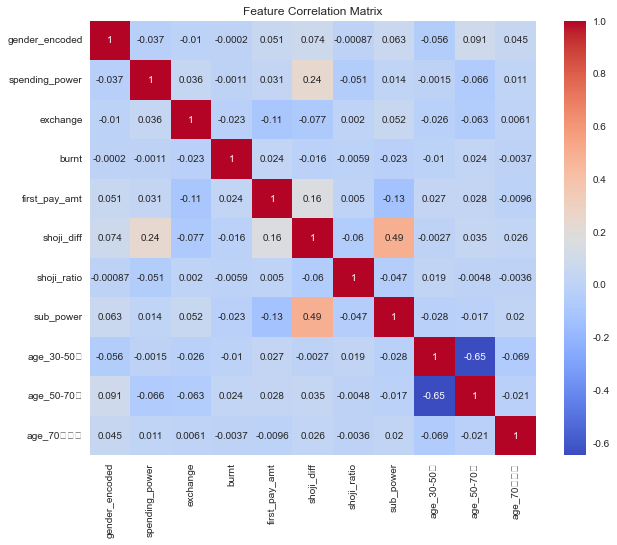


VIF Values:
                     VIF
age_30-50세      1.782781
age_50-70세      1.802336
age_70세이상       1.015550
burnt           1.002092
exchange        1.035595
first_pay_amt   1.099439
gender_encoded  1.021325
shoji_diff      1.554664
shoji_ratio     1.006216
spending_power  1.098589
sub_power       1.447486

MinMax Scaling Results:
       gender_encoded  spending_power     exchange        burnt  \
count     8786.000000     8786.000000  8786.000000  8786.000000   
mean         0.315643        0.888386     0.081785     0.004251   
std          0.439060        0.183845     0.199415     0.054131   
min          0.000000        0.000000     0.000000     0.000000   
25%          0.000000        0.854400     0.000000     0.000000   
50%          0.000000        0.969536     0.000000     0.000000   
75%          0.974472        0.995009     0.000000     0.000000   
max          1.000000        1.000000     1.000000     1.000000   

       first_pay_amt   shoji_diff   shoji_ratio    sub_pow

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


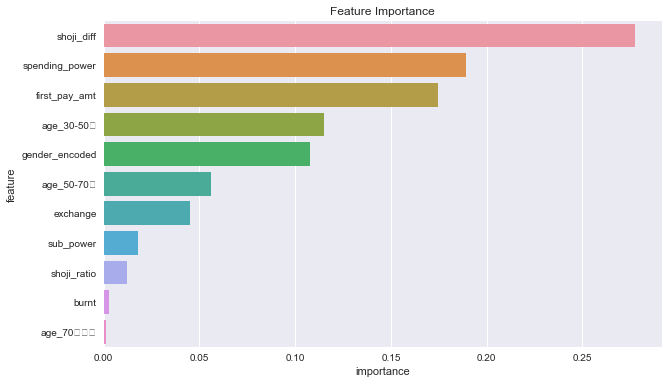

In [260]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from numpy import log1p
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# 1. 기본 데이터 준비
X = origin_lg[['age','gender', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'pre_shoji', 'post_shoji_1', 'sub_power']]
y = origin_lg['survived']

le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(X['gender'])

# 20대를 포함한 연령대 재조정
X['age_group'] = pd.cut(X['age'], 
                       bins=[0, 30, 50, 70, 100],  # 20대 구간 추가
                       labels=['30세미만', '30-50세', '50-70세', '70세이상'])
# 다시 원핫 인코딩
age_dummies = pd.get_dummies(X['age_group'], prefix='age',drop_first=True) + 1e-8
# age_dummies = pd.get_dummies(X['age'], prefix='age',drop_first=True)

# shoji 다중공선성 해결
X['shoji_diff'] = X['pre_shoji'] - X['post_shoji_1']
X['shoji_ratio'] = X['post_shoji_1'] / (X['pre_shoji'] + 1e-8)

X = pd.concat([
    X[['gender_encoded', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'shoji_diff', 'shoji_ratio', 'sub_power']]
        ,age_dummies], axis=1)
# X = X.drop(['age','gender'],axis=1)
# print(X.columns)

y = y.astype(int)
X = X.astype(float)

# 2. 데이터 변환 (왜곡된 변수 처리)
X_transformed = X.copy()
X_transformed['exchange'] = np.log1p(X_transformed['exchange'])
X_transformed['burnt'] = np.log1p(X_transformed['burnt'])
X_transformed['spending_power'] = np.sqrt(X_transformed['spending_power'])

# 3. 상관관계 분석
plt.figure(figsize=(10,8))
correlation = X_transformed.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. VIF 계산
def calculate_vif(X):
    vif_dict = {}
    for column in X.columns:
        not_column = [col for col in X.columns if col != column]
        y = X[column]
        X_others = X[not_column]
        r2 = r2_score(y, LinearRegression().fit(X_others, y).predict(X_others))
        vif = 1/(1-r2)
        vif_dict[column] = vif
    return pd.DataFrame({'VIF': vif_dict})

vif_df = calculate_vif(X_transformed)
print("\nVIF Values:")
print(vif_df)

# 5. SMOTE 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# 6. 다양한 스케일러 적용 및 비교
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_dfs = {}
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_resampled)
    scaled_dfs[scaler_name] = pd.DataFrame(X_scaled, 
                                         columns=X_resampled.columns)
    
    # 스케일링 결과 통계 출력
    print(f"\n{scaler_name} Scaling Results:")
    print(scaled_dfs[scaler_name].describe())

# 7. 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_dfs['Standard'], y_resampled)  # StandardScaler 사용

feature_importance = pd.DataFrame({
    'feature': X_transformed.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. 최종 전처리된 데이터셋 준비
# StandardScaler를 기본으로 사용
X_final = scaled_dfs['Standard']
y_final = y_resampled

# 최종 데이터셋 통계 확인
print("\nFinal Dataset Statistics:")
print(X_final.describe())

# 결과 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

In [261]:
vif_df

,VIF
age_30-50세,1.782781
age_50-70세,1.802336
age_70세이상,1.015550
burnt,1.002092
exchange,1.035595
first_pay_amt,1.099439
gender_encoded,1.021325
shoji_diff,1.554664
shoji_ratio,1.006216
spending_power,1.098589


tst 2

<ipython-input-266-644ac5123448>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['exchange'] = (X['exchange'] > 0).astype(int)
<ipython-input-266-644ac5123448>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['burnt'] = (X['burnt'] > 0).astype(int)
<ipython-input-266-644ac5123448>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

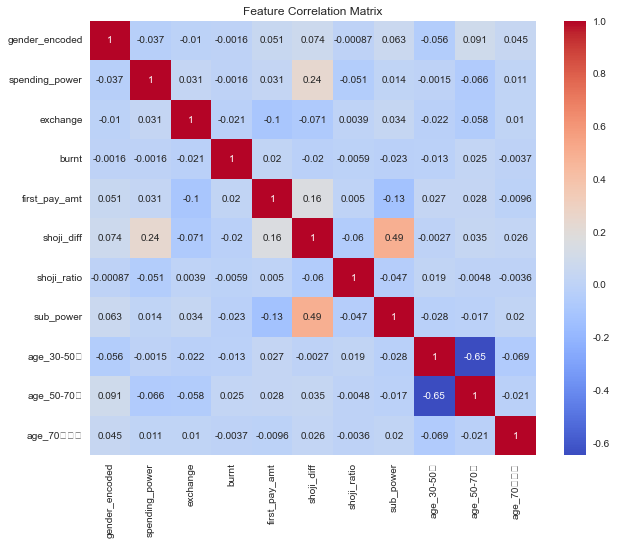


VIF Values:
                     VIF
age_30-50세      1.780935
age_50-70세      1.800236
age_70세이상       1.015546
burnt           1.002073
exchange        1.027551
first_pay_amt   1.099635
gender_encoded  1.021328
shoji_diff      1.549236
shoji_ratio     1.006230
spending_power  1.097451
sub_power       1.442417

MinMax Scaling Results:
       gender_encoded  spending_power     exchange        burnt  \
count     8786.000000     8786.000000  8786.000000  8786.000000   
mean         0.315565        0.888378     0.138672     0.005631   
std          0.439049        0.183850     0.330431     0.070913   
min          0.000000        0.000000     0.000000     0.000000   
25%          0.000000        0.854400     0.000000     0.000000   
50%          0.000000        0.969536     0.000000     0.000000   
75%          0.974472        0.995009     0.000000     0.000000   
max          1.000000        1.000000     1.000000     1.000000   

       first_pay_amt   shoji_diff   shoji_ratio    sub_pow

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


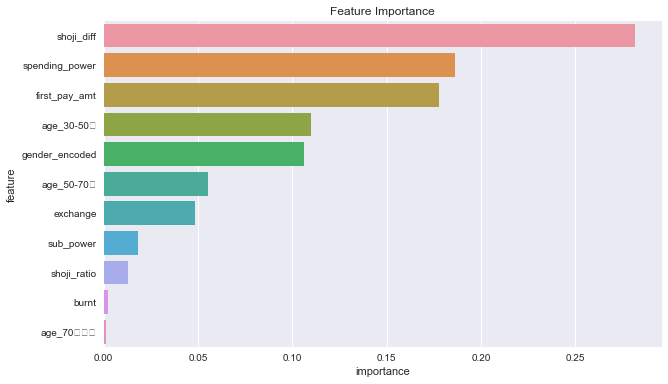

In [266]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from numpy import log1p
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# 1. 기본 데이터 준비
X = origin_lg[['age','gender', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'pre_shoji', 'post_shoji_1', 'sub_power']]
y = origin_lg['survived']

X['exchange'] = (X['exchange'] > 0).astype(int)
X['burnt'] = (X['burnt'] > 0).astype(int)

le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(X['gender'])

# 20대를 포함한 연령대 재조정
X['age_group'] = pd.cut(X['age'], 
                       bins=[0, 30, 50, 70, 100],  # 20대 구간 추가
                       labels=['30세미만', '30-50세', '50-70세', '70세이상'])
# 다시 원핫 인코딩
age_dummies = pd.get_dummies(X['age_group'], prefix='age',drop_first=True) + 1e-8
# age_dummies = pd.get_dummies(X['age'], prefix='age',drop_first=True)

# shoji 다중공선성 해결
X['shoji_diff'] = X['pre_shoji'] - X['post_shoji_1']
X['shoji_ratio'] = X['post_shoji_1'] / (X['pre_shoji'] + 1e-8)

X = pd.concat([
    X[['gender_encoded', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'shoji_diff', 'shoji_ratio', 'sub_power']]
        ,age_dummies], axis=1)
# X = X.drop(['age','gender'],axis=1)
# print(X.columns)

y = y.astype(int)
X = X.astype(float)

# 2. 데이터 변환 (왜곡된 변수 처리)
X_transformed = X.copy()
X_transformed['spending_power'] = np.sqrt(X_transformed['spending_power'])

# 3. 상관관계 분석
plt.figure(figsize=(10,8))
correlation = X_transformed.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. VIF 계산
def calculate_vif(X):
    vif_dict = {}
    for column in X.columns:
        not_column = [col for col in X.columns if col != column]
        y = X[column]
        X_others = X[not_column]
        r2 = r2_score(y, LinearRegression().fit(X_others, y).predict(X_others))
        vif = 1/(1-r2)
        vif_dict[column] = vif
    return pd.DataFrame({'VIF': vif_dict})

vif_df = calculate_vif(X_transformed)
print("\nVIF Values:")
print(vif_df)

# 5. SMOTE 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# 6. 다양한 스케일러 적용 및 비교
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_dfs = {}
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_resampled)
    scaled_dfs[scaler_name] = pd.DataFrame(X_scaled, 
                                         columns=X_resampled.columns)
    
    # 스케일링 결과 통계 출력
    print(f"\n{scaler_name} Scaling Results:")
    print(scaled_dfs[scaler_name].describe())

# 7. 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_dfs['Standard'], y_resampled)  # StandardScaler 사용

feature_importance = pd.DataFrame({
    'feature': X_transformed.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. 최종 전처리된 데이터셋 준비
# StandardScaler를 기본으로 사용
X_final = scaled_dfs['Standard']
y_final = y_resampled

# 최종 데이터셋 통계 확인
print("\nFinal Dataset Statistics:")
print(X_final.describe())

# 결과 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

재산 추가

In [293]:
origin_lg.describe()

,age,post_shoji_1,burnt,exchange,sub_power,pre_shoji,current_shoji,first_pay_amt,first_sub_pay_amt,spending_power,survived
count,5776.0,5776.0,5776.0,5776.0,5776.000000,5776.0,5776.0,5776.0,5776.0,5776.000000,5776.000000
mean,45.495152,1525.070118,9.726974,82.34072,0.272334,8180.09072,1544.184557,17924.658934,7245.551939,0.815583,0.239439
std,10.721051,4406.9929,196.878778,558.184868,0.445199,10922.32605,4513.182627,18123.146061,8802.944837,0.240359,0.426778
min,10.0,0.0,0.0,0.0,0.000000,0.0,0.0,3900.0,0.0,0.000000,0.000000
25%,40.0,31.0,0.0,0.0,0.000000,423.75,3.0,9900.0,913.0,0.710000,0.000000
50%,50.0,180.0,0.0,0.0,0.000000,3798.0,102.5,12900.0,3900.0,0.930000,0.000000
75%,50.0,861.25,0.0,0.0,1.000000,12346.25,812.75,19900.0,10804.25,0.990000,0.000000
max,80.0,54568.0,9180.0,10000.0,1.000000,88568.0,54461.0,321300.0,93200.0,1.000000,1.000000


<Axes: >

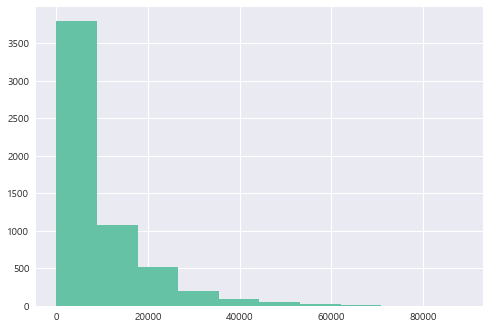

In [294]:
origin_lg.pre_shoji.hist()

<Axes: >

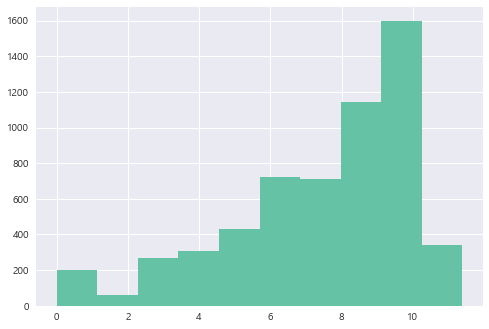

In [296]:
np.log1p(origin_lg.pre_shoji).hist()

In [300]:
np.log1p(origin_lg.pre_shoji).describe()

count       5776.0
mean      7.422507
std       2.573446
min            0.0
25%         6.0515
50%       8.242493
75%       9.421189
max      11.391537
Name: pre_shoji, dtype: Float64

In [299]:
np.sqrt(origin_lg.pre_shoji).describe()

count        5776.0
mean      70.304678
std        56.90258
min             0.0
25%       20.585186
50%       61.627911
75%      111.113681
max      297.603763
Name: pre_shoji, dtype: Float64

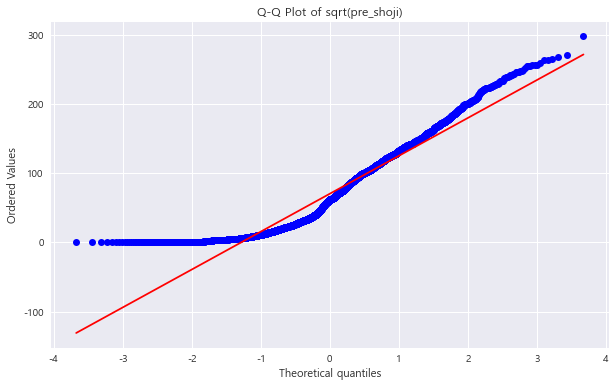

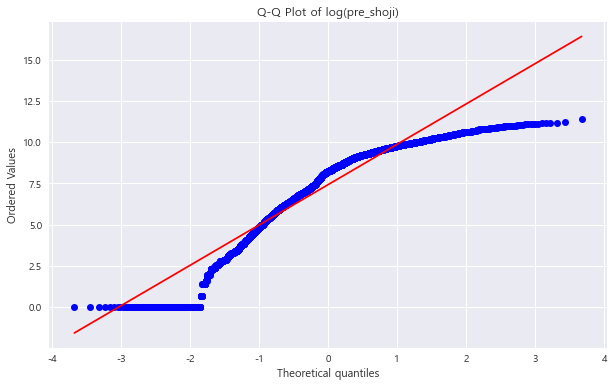

In [311]:
# 데이터를 float 타입으로 변환 후 QQ plot 생성
pre_shoji_array = origin_lg.pre_shoji.astype(float)

# 제곱근 변환
pre_shoji_sqrt = np.sqrt(pre_shoji_array)

plt.figure(figsize=(10, 6))
stats.probplot(pre_shoji_sqrt, dist="norm", plot=plt)
plt.title('Q-Q Plot of sqrt(pre_shoji)')
plt.show()

# 로그 변환
pre_shoji_log = np.log1p(pre_shoji_array)

plt.figure(figsize=(10, 6))
stats.probplot(pre_shoji_log, dist="norm", plot=plt)
plt.title('Q-Q Plot of log(pre_shoji)')
plt.show()

<Axes: >

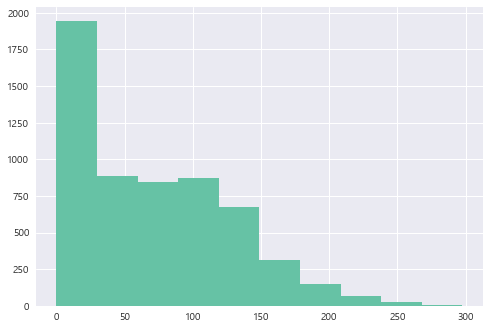

In [297]:
np.sqrt(origin_lg.pre_shoji).hist()

<ipython-input-312-55e839519428>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['exchange'] = (X['exchange'] > 0).astype(int)
<ipython-input-312-55e839519428>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['burnt'] = (X['burnt'] > 0).astype(int)
<ipython-input-312-55e839519428>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

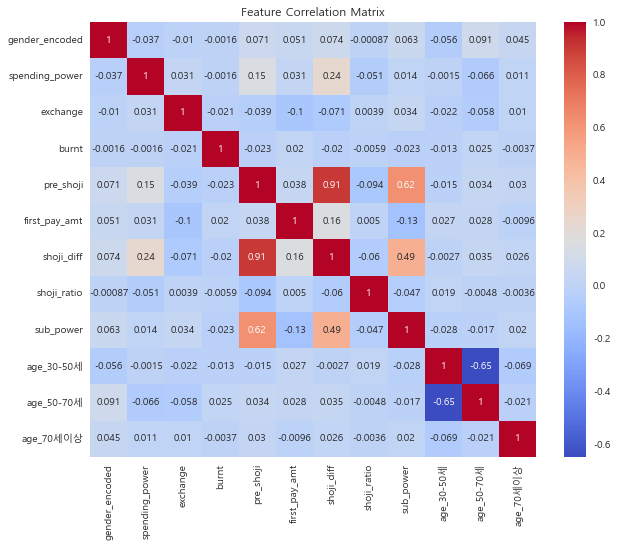


VIF Values:
                     VIF
age_30-50세      1.780950
age_50-70세      1.800870
age_70세이상       1.015698
burnt           1.002080
exchange        1.027997
first_pay_amt   1.127995
gender_encoded  1.021372
pre_shoji       7.638738
shoji_diff      6.720463
shoji_ratio     1.016469
spending_power  1.113079
sub_power       1.771462

MinMax Scaling Results:
       gender_encoded  spending_power     exchange        burnt    pre_shoji  \
count     8786.000000     8786.000000  8786.000000  8786.000000  8786.000000   
mean         0.315340        0.888697     0.138707     0.005649     0.225069   
std          0.438727        0.184562     0.330392     0.071115     0.187788   
min          0.000000        0.000000     0.000000     0.000000     0.000000   
25%          0.000000        0.855161     0.000000     0.000000     0.057737   
50%          0.000000        0.969536     0.000000     0.000000     0.200925   
75%          0.965401        0.995003     0.000000     0.000000     0.355754 

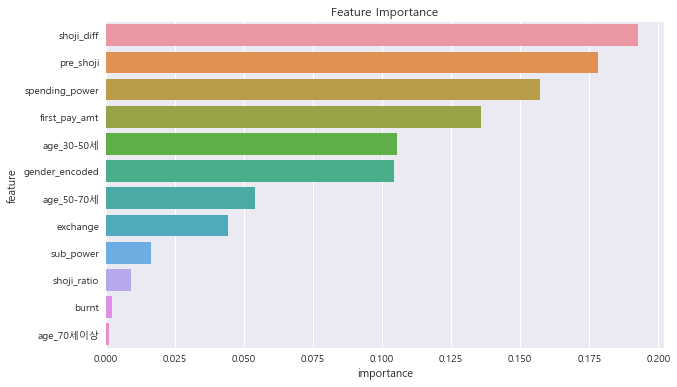

In [312]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from numpy import log1p
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# 1. 기본 데이터 준비
X = origin_lg[['age','gender', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'pre_shoji', 'post_shoji_1', 'sub_power']]
y = origin_lg['survived']

X['exchange'] = (X['exchange'] > 0).astype(int)
X['burnt'] = (X['burnt'] > 0).astype(int)

le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(X['gender'])

# 20대를 포함한 연령대 재조정
X['age_group'] = pd.cut(X['age'], 
                       bins=[0, 30, 50, 70, 100],  # 20대 구간 추가
                       labels=['30세미만', '30-50세', '50-70세', '70세이상'])
# 다시 원핫 인코딩
age_dummies = pd.get_dummies(X['age_group'], prefix='age',drop_first=True) + 1e-8
# age_dummies = pd.get_dummies(X['age'], prefix='age',drop_first=True)

# shoji 다중공선성 해결
X['shoji_diff'] = X['pre_shoji'] - X['post_shoji_1']
X['shoji_ratio'] = X['post_shoji_1'] / (X['pre_shoji'] + 1e-8)

X = pd.concat([
    X[['gender_encoded', 'spending_power', 'exchange', 'burnt','pre_shoji', 'first_pay_amt', 
               'shoji_diff', 'shoji_ratio', 'sub_power']]
        ,age_dummies], axis=1)
# X = X.drop(['age','gender'],axis=1)
# print(X.columns)

y = y.astype(int)
X = X.astype(float)

# 2. 데이터 변환 (왜곡된 변수 처리)
X_transformed = X.copy()
X_transformed['spending_power'] = np.sqrt(X_transformed['spending_power'])
X_transformed['pre_shoji'] = np.sqrt(X_transformed['pre_shoji'])

# 3. 상관관계 분석
plt.figure(figsize=(10,8))
correlation = X_transformed.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. VIF 계산
def calculate_vif(X):
    vif_dict = {}
    for column in X.columns:
        not_column = [col for col in X.columns if col != column]
        y = X[column]
        X_others = X[not_column]
        r2 = r2_score(y, LinearRegression().fit(X_others, y).predict(X_others))
        vif = 1/(1-r2)
        vif_dict[column] = vif
    return pd.DataFrame({'VIF': vif_dict})

vif_df = calculate_vif(X_transformed)
print("\nVIF Values:")
print(vif_df)

# 5. SMOTE 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# 6. 다양한 스케일러 적용 및 비교
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_dfs = {}
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_resampled)
    scaled_dfs[scaler_name] = pd.DataFrame(X_scaled, 
                                         columns=X_resampled.columns)
    
    # 스케일링 결과 통계 출력
    print(f"\n{scaler_name} Scaling Results:")
    print(scaled_dfs[scaler_name].describe())

# 7. 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_dfs['Standard'], y_resampled)  # StandardScaler 사용

feature_importance = pd.DataFrame({
    'feature': X_transformed.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. 최종 전처리된 데이터셋 준비
# StandardScaler를 기본으로 사용
X_final = scaled_dfs['Standard']
y_final = y_resampled

# 최종 데이터셋 통계 확인
print("\nFinal Dataset Statistics:")
print(X_final.describe())

# 결과 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

### reg

In [313]:
# 로지스틱 회귀 분석을 위한 데이터 준비
import statsmodels.api as sm

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 적합
model = sm.Logit(y, X)
results = model.fit()

# 결과 출력
print(results.summary())


Optimization terminated successfully.
         Current function value: 0.530630
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 5776
Model:                          Logit   Df Residuals:                     5763
Method:                           MLE   Df Model:                           12
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                 0.03598
Time:                        18:50:34   Log-Likelihood:                -3064.9
converged:                       True   LL-Null:                       -3179.3
Covariance Type:            nonrobust   LLR p-value:                 3.604e-42
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.4812      0.174     -8.520      0.000      -1.822      -1.140
gender_encoded   

In [314]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 5776
Model:                          Logit   Df Residuals:                     5763
Method:                           MLE   Df Model:                           12
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                 0.03598
Time:                        18:53:09   Log-Likelihood:                -3064.9
converged:                       True   LL-Null:                       -3179.3
Covariance Type:            nonrobust   LLR p-value:                 3.604e-42
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.4812      0.174     -8.520      0.000      -1.822      -1.140
gender_encoded    -0.1447      0.069     -2.090      0.037      -0.280      -0.009
spending_power     1.4169      0.179      7.903      0.000       1.066       1.768
exchange          -0.5450      0.096     -5.674      0.000      -0.733      -0.357
burnt              0.2512      0.384      0.655      0.513      -0.501       1.004
pre_shoji       3.859e-05   9.13e-06      4.229      0.000    2.07e-05    5.65e-05
first_pay_amt  -7.344e-07   1.76e-06     -0.417      0.677   -4.19e-06    2.72e-06
shoji_diff     -8.264e-05   1.17e-05     -7.067      0.000      -0.000   -5.97e-05
shoji_ratio     1.368e-11   8.64e-12      1.583      0.113   -3.25e-12    3.06e-11
sub_power          0.1115      0.092      1.205      0.228      -0.070       0.293
age_30-50세        -0.6078      0.082     -7.421      0.000      -0.768      -0.447
age_50-70세        -0.8253      0.112     -7.400      0.000      -1.044      -0.607
age_70세이상         -0.3891      0.667     -0.583      0.560      -1.697       0.919
==================================================================================
"""

unique 

## 영향력 테스트

Original spending_power statistics:
count    5776.000000
mean        0.815583
std         0.240359
min         0.000000
25%         0.710000
50%         0.930000
75%         0.990000
max         1.000000
Name: spending_power, dtype: float64

Sqrt transformed spending_power statistics:
count    5776.000000
mean        0.883330
std         0.187930
min         0.000000
25%         0.842615
50%         0.964365
75%         0.994987
max         1.000000
Name: spending_power, dtype: float64

Final scaled spending_power statistics:
count    5.776000e+03
mean    -1.845246e-16
std      1.000087e+00
min     -4.700718e+00
25%     -2.166684e-01
50%      4.312354e-01
75%      5.941950e-01
max      6.208698e-01
dtype: float64

이탈 확률 변화 분석 (기준값: 0.93)
--------------------------------------------------------------------------------
 percentage_increase  original_value  increased_value  odds_ratio  base_prob  new_prob  probability_change
                 0.0            0.93            0.930      1.000

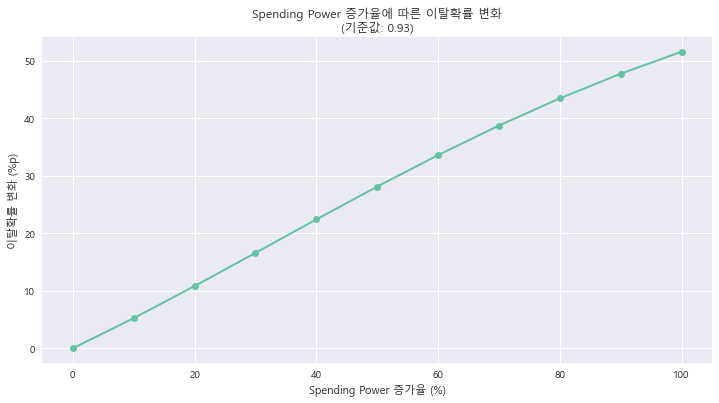

In [315]:
# 1. 원본 데이터의 spending_power에 대한 통계 확인
spending_stats = X['spending_power'].describe()
print("Original spending_power statistics:")
print(spending_stats)

# 2. sqrt 변환 후 통계
sqrt_spending = np.sqrt(X['spending_power'])
print("\nSqrt transformed spending_power statistics:")
print(sqrt_spending.describe())

# 3. StandardScaler 적용된 최종 값의 통계
scaler = StandardScaler()
final_spending = scaler.fit_transform(sqrt_spending.values.reshape(-1, 1))
print("\nFinal scaled spending_power statistics:")
print(pd.Series(final_spending.flatten()).describe())

def calculate_churn_probability(base_value, percentage_increase, scaler_mean=scaler.mean_[0], scaler_std=scaler.scale_[0]):
    """
    spending_power의 증가에 따른 이탈확률 변화 계산
    실제 데이터의 스케일링 파라미터 사용
    """
    original_value = base_value
    increased_value = base_value * (1 + percentage_increase)
    
    # sqrt 변환
    sqrt_original = np.sqrt(original_value)
    sqrt_increased = np.sqrt(increased_value)
    
    # 실제 데이터로 학습된 StandardScaler 적용
    scaled_original = (sqrt_original - scaler_mean) / scaler_std
    scaled_increased = (sqrt_increased - scaler_mean) / scaler_std
    
    # 로지스틱 회귀 계수 적용
    coefficient = 1.0736
    logit_change = (scaled_increased - scaled_original) * coefficient
    
    odds_ratio = np.exp(logit_change)
    
    # 기준 확률은 데이터의 원래 이탈률 사용
    base_prob = y.mean()
    new_prob = (base_prob * odds_ratio) / (1 + (base_prob * (odds_ratio - 1)))
    
    return {
        'percentage_increase': percentage_increase * 100,
        'original_value': original_value,
        'increased_value': increased_value,
        'odds_ratio': odds_ratio,
        'base_prob': base_prob * 100,
        'new_prob': new_prob * 100,
        'probability_change': (new_prob - base_prob) * 100
    }

# spending_power의 중앙값을 기준값으로 사용
base_value = X['spending_power'].median()
increases = np.arange(0, 1.1, 0.1)
results = [calculate_churn_probability(base_value, i) for i in increases]

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame(results)
print("\n이탈 확률 변화 분석 (기준값: {:.2f})".format(base_value))
print("-" * 80)
print(df_results.round(4).to_string(index=False))

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_results['percentage_increase'], df_results['probability_change'], 
         marker='o', linewidth=2)
plt.title(f'Spending Power 증가율에 따른 이탈확률 변화\n(기준값: {base_value:.2f})')
plt.xlabel('Spending Power 증가율 (%)')
plt.ylabel('이탈확률 변화 (%p)')
plt.grid(True)
plt.show()

Original pre_shoji statistics:
count     5776.00000
mean      8180.09072
std      10922.32605
min          0.00000
25%        423.75000
50%       3798.00000
75%      12346.25000
max      88568.00000
Name: pre_shoji, dtype: float64

Sqrt transformed pre_shoji statistics:
count    5776.000000
mean       70.304678
std        56.902580
min         0.000000
25%        20.585186
50%        61.627911
75%       111.113681
max       297.603763
Name: pre_shoji, dtype: float64

Final scaled pre_shoji statistics:
count    5.776000e+03
mean     9.841312e-18
std      1.000087e+00
min     -1.235634e+00
25%     -8.738408e-01
50%     -1.524978e-01
75%      7.172352e-01
max      3.994876e+00
dtype: float64

이탈 확률 변화 분석 (기준값: 3798.00)
--------------------------------------------------------------------------------
 percentage_increase  original_value  increased_value  odds_ratio  base_prob  new_prob  probability_change
                 0.0          3798.0           3798.0      1.0000    23.9439   23.9439

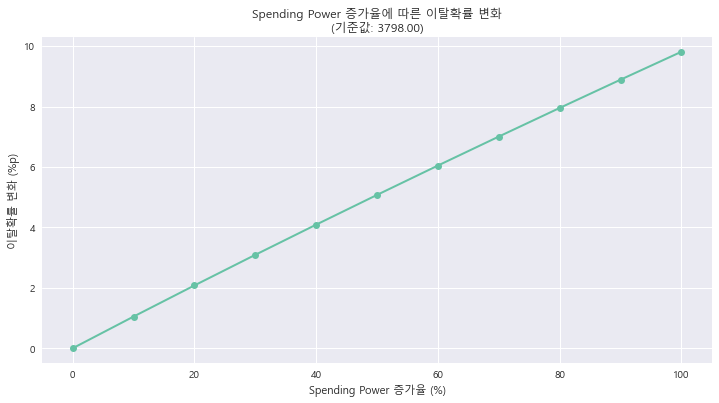

In [317]:
# 1. 원본 데이터의 pre_shoji에 대한 통계 확인
spending_stats = X['pre_shoji'].describe()
print("Original pre_shoji statistics:")
print(spending_stats)

# 2. sqrt 변환 후 통계
sqrt_spending = np.sqrt(X['pre_shoji'])
print("\nSqrt transformed pre_shoji statistics:")
print(sqrt_spending.describe())

# 3. StandardScaler 적용된 최종 값의 통계
scaler = StandardScaler()
final_spending = scaler.fit_transform(sqrt_spending.values.reshape(-1, 1))
print("\nFinal scaled pre_shoji statistics:")
print(pd.Series(final_spending.flatten()).describe())

def calculate_churn_probability(base_value, percentage_increase, scaler_mean=scaler.mean_[0], scaler_std=scaler.scale_[0]):
    """
    pre_shoji의 증가에 따른 이탈확률 변화 계산
    실제 데이터의 스케일링 파라미터 사용
    """
    original_value = base_value
    increased_value = base_value * (1 + percentage_increase)
    
    # sqrt 변환
    sqrt_original = np.sqrt(original_value)
    sqrt_increased = np.sqrt(increased_value)
    
    # 실제 데이터로 학습된 StandardScaler 적용
    scaled_original = (sqrt_original - scaler_mean) / scaler_std
    scaled_increased = (sqrt_increased - scaler_mean) / scaler_std
    
    # 로지스틱 회귀 계수 적용
    coefficient = 1.0736
    logit_change = (scaled_increased - scaled_original) * coefficient
    
    odds_ratio = np.exp(logit_change)
    
    # 기준 확률은 데이터의 원래 이탈률 사용
    base_prob = y.mean()
    new_prob = (base_prob * odds_ratio) / (1 + (base_prob * (odds_ratio - 1)))
    
    return {
        'percentage_increase': percentage_increase * 100,
        'original_value': original_value,
        'increased_value': increased_value,
        'odds_ratio': odds_ratio,
        'base_prob': base_prob * 100,
        'new_prob': new_prob * 100,
        'probability_change': (new_prob - base_prob) * 100
    }

# pre_shoji의 중앙값을 기준값으로 사용
base_value = X['pre_shoji'].median()
increases = np.arange(0, 1.1, 0.1)
results = [calculate_churn_probability(base_value, i) for i in increases]

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame(results)
print("\n이탈 확률 변화 분석 (기준값: {:.2f})".format(base_value))
print("-" * 80)
print(df_results.round(4).to_string(index=False))

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_results['percentage_increase'], df_results['probability_change'], 
         marker='o', linewidth=2)
plt.title(f'Spending Power 증가율에 따른 이탈확률 변화\n(기준값: {base_value:.2f})')
plt.xlabel('Spending Power 증가율 (%)')
plt.ylabel('이탈확률 변화 (%p)')
plt.grid(True)
plt.show()

In [318]:
df_results

,percentage_increase,original_value,increased_value,odds_ratio,base_prob,new_prob,probability_change
0,0.0,3798.0,3798.0,1.000000,23.943906,23.943906,0.000000
1,10.0,3798.0,4177.8,1.058399,23.943906,24.992737,1.048831
2,20.0,3798.0,4557.6,1.117382,23.943906,26.023096,2.079191
3,30.0,3798.0,4937.4,1.177041,23.943906,27.036853,3.092948
4,40.0,3798.0,5317.2,1.237451,23.943906,28.035453,4.091548
5,50.0,3798.0,5697.0,1.298677,23.943906,29.020027,5.076121
6,60.0,3798.0,6076.8,1.360773,23.943906,29.991469,6.047564
7,70.0,3798.0,6456.6,1.423790,23.943906,30.950492,7.006587
8,80.0,3798.0,6836.4,1.487771,23.943906,31.897668,7.953762
9,90.0,3798.0,7216.2,1.552754,23.943906,32.833456,8.889551
